###  Exercise project 3 – Support Vector Machines. This notebook will create SVM-classification model. I will use dataset from Project_2:HR Employee Attrition dataset (https://www.kaggle.com/datasets/saurabhbadole/hr-employee-attrition). Target variable - "Attrition" column (show how likely someone is to quit).The cleaning/optimisation phase is copied from Project_1, so you can scrow down straight to "scale of  the regression target for SVC" 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# pip install scikit-learn
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
# load the dataset:
df = pd.read_csv("HR-Employee-Attrition.csv")

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

In [4]:
columns_to_drop = [
    'Over18',
    'EmployeeCount',
    'EmployeeNumber',
    'Department',
    'EducationField',
    "Education",
    "MaritalStatus",
    "OverTime",
    "JobRole",
    "StandardHours",
    'Gender',
    'HourlyRate',
    'MonthlyRate',
    'RelationshipSatisfaction',
    'DistanceFromHome',
    'PerformanceRating',
    'NumCompaniesWorked',
    'PercentSalaryHike',
]

df = df.drop(columns_to_drop, axis=1)

In [5]:
# use of OneHotEncoder for "BusinessTravel" column , it will create multiple columns with numeric values:
from sklearn.preprocessing import OneHotEncoder
variables = ["BusinessTravel"]
             
# use encoder:
encoder = OneHotEncoder(sparse_output=False).set_output(transform="pandas")
one_hot_encoded = encoder.fit_transform(df[variables]).astype(int)
df = pd.concat([df,one_hot_encoded],axis=1).drop(columns=variables)

In [6]:
# next we will remove one new boolean variable "BusinessTravel_Travel_Rarely" (since it's going to be represented
# by a straight line of zeroes)
df = df.drop("BusinessTravel_Travel_Rarely", axis=1)

In [7]:
from sklearn.preprocessing import LabelEncoder
# list of all boolean variables we want to convert
variables = ['Attrition']

# initalize encoder and convert everything
encoder = LabelEncoder()
df[variables] = df[variables].apply(encoder.fit_transform)

###  X/y -split + VIF -test

In [8]:
 # use everything else except, the target
X = df.drop("Attrition", axis=1)

# our target variable is y
y = df['Attrition']

In [9]:
# Finding columns with potential multicollinearity (VIF-test)
# pip install statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor 

# VIF dataframe 
# VIF = Variance Inflation Factor
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  

# variables with high VIF-value 
# can mean multlicollinearity (variables providing same linear
# relationships in the data, confusing the logistic regression
print(vif_data)

                             feature        VIF
0                                Age  26.256503
1                          DailyRate   4.796366
2            EnvironmentSatisfaction   6.701236
3                     JobInvolvement  13.036970
4                           JobLevel  48.877574
5                    JobSatisfaction   6.567311
6                      MonthlyIncome  30.994836
7                   StockOptionLevel   1.881405
8                  TotalWorkingYears  13.345172
9              TrainingTimesLastYear   5.397656
10                   WorkLifeBalance  13.027862
11                    YearsAtCompany  10.011322
12                YearsInCurrentRole   6.397829
13           YearsSinceLastPromotion   2.440140
14              YearsWithCurrManager   6.440338
15         BusinessTravel_Non-Travel   1.151701
16  BusinessTravel_Travel_Frequently   1.268554


In [10]:
columns_to_drop_after_vif = [
    'Age',
    'MonthlyIncome',
    'WorkLifeBalance',
    'YearsAtCompany', 
    'JobLevel',
    'JobInvolvement',
    'YearsInCurrentRole', 
    'EnvironmentSatisfaction',
]

df = df.drop(columns_to_drop_after_vif, axis=1)

In [11]:
df.describe()

,Attrition,DailyRate,JobSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,0.161224,802.485714,2.728571,0.793878,11.279592,2.799320,2.187755,4.123129,0.102041,0.188435
std,0.367863,403.509100,1.102846,0.852077,7.780782,1.289271,3.222430,3.568136,0.302805,0.391193
min,0.000000,102.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,465.000000,2.000000,0.000000,6.000000,2.000000,0.000000,2.000000,0.000000,0.000000
50%,0.000000,802.000000,3.000000,1.000000,10.000000,3.000000,1.000000,3.000000,0.000000,0.000000
75%,0.000000,1157.000000,4.000000,1.000000,15.000000,3.000000,3.000000,7.000000,0.000000,0.000000
max,1.000000,1499.000000,4.000000,3.000000,40.000000,6.000000,15.000000,17.000000,1.000000,1.000000


In [14]:
len(df.columns)

10

#### Explanation how I did cleaning of the dataset is it Project_2. At this stage I have the same amount of rows and columns and dataset is ready for  X/y and train/test split

In [15]:
# use everything else except, the target
X = df.drop("Attrition", axis=1)

# our target variable is y
y = df['Attrition']

In [16]:
# create train/test split with scikit-learn's helper function
# random_state is optional, you can lock down the randomness for same results everytime
# this is sometimes helpful when you want to minimize randomness in order to maximize optimizations
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

###  Create the SVM classifier (SVC) model and fit the data

In [17]:
 # code as usual
# model = LogisticRegression()

# you have to wrap the linear SVC into CalibratedClassifierCV
# for probabilities to work correctly in error metrics
# in other words, because LinearSVC() doesn't support probability=True
# we have to wrap it around CalibratedClassifierCV()
# model = make_pipeline(StandardScaler(), CalibratedClassifierCV(svm.LinearSVC()))

model = make_pipeline(StandardScaler(), svm.SVC(probability=True))
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))])

###  Classification error metrics

In [18]:
# get the test predictions for metrics as usual
predictions = model.predict(X_test)

In [19]:
# print the classification report based on true values and predictions
print(classification_report(y_test, predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       307
           1       0.00      0.00      0.00        61

    accuracy                           0.83       368
   macro avg       0.42      0.50      0.45       368
weighted avg       0.70      0.83      0.76       368


Model overall accuracy: 83.42%


c:\Pro\Python311_amd64\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Pro\Python311_amd64\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Pro\Python311_amd64\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Logitic regression ML model has 87% of accuracy, better than this one. 

[[307   0]
 [ 61   0]]


<Axes: >

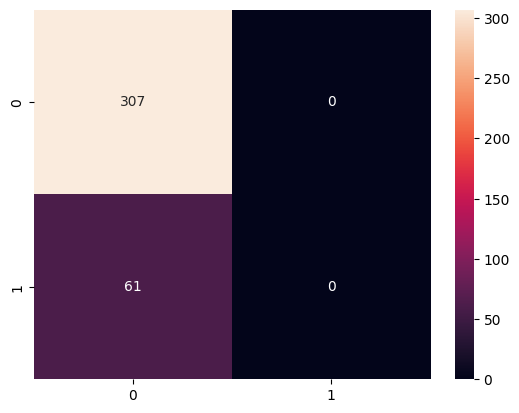

In [20]:
print(confusion_matrix(y_test, predictions))

# if you want a more graphical version of this, try:
# the fmt-parameter will change to decimal format from scientific format
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='g')

#### So, my model never predicts class 1 : 61 (False Negatives): Model predicted 0, but the actual was 1 — this is a problem.

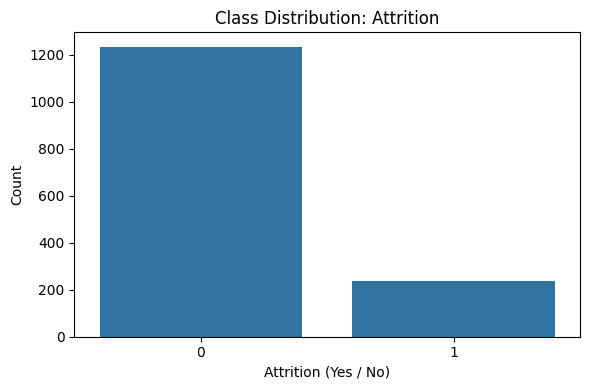

In [21]:
# Plot the class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Attrition', data=df)
plt.title("Class Distribution: Attrition")
plt.xlabel("Attrition (Yes / No)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### This can be one of the reson why metrics are so bad -> target variable are very imbalanced, the SVM might just predict the majority class to get high "accuracy" but low real performance. Another reason can be wrong kernel or default hyperparameters. I will run a grid search to find better parameters. 

####   It does not make practical sense to test this model further. Any real-world usage would likely result in misleading predictions.